In [ ]:
pip install OpenEXR numpy

In [2]:
import OpenEXR
import Imath
import numpy as np
import os

def get_exr_info(exr_file):
    file = OpenEXR.InputFile(exr_file)
    header = file.header()
    
    # Get image dimensions
    dw = header['dataWindow']
    width = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1
    
    # Get the number of channels
    channels = file.header()['channels'].keys()
    num_channels = len(channels)
    
    return width, height, num_channels, channels

# Folder path to your images
image_folder = '/kaggle/input/kaist-spectral/Dataset'

# Loop through all images and check their dimensions and channels
for image_name in os.listdir(image_folder):
    if image_name.endswith('.exr'):
        image_path = os.path.join(image_folder, image_name)
        try:
            width, height, num_channels, channels = get_exr_info(image_path)
            print(f'{image_name} - Width: {width}, Height: {height}, Channels: {num_channels}')
        except Exception as e:
            print(f"Failed to process {image_name}: {e}")

scene03_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene01_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene17_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene12_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene13_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene11_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene04_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene02_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene10_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene19_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene25_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene22_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene23_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene29_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene28_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene26_re

In [3]:
def load_exr_to_pixel_data(exr_file):
    file = OpenEXR.InputFile(exr_file)
    header = file.header()

    dw = header['dataWindow']
    width = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1
    channels = header['channels'].keys()

    # Define the pixel type (float)
    pt = Imath.PixelType(Imath.PixelType.FLOAT)

    # Read each channel's data
    pixel_data = []
    for channel in channels:
        #convert raw pixel data into floating point numbers
        channel_data = np.frombuffer(file.channel(channel, pt), dtype=np.float32)
        channel_data = channel_data.reshape((height, width))  # Reshape into 2D
        pixel_data.append(channel_data)

    # Stack all the channel data into a (height, width, num_channels) array
    pixel_data = np.stack(pixel_data, axis=-1)

    # Flatten the image into an array of shape (height * width, num_channels)
    pixel_data = pixel_data.reshape(-1, len(channels))  # Each pixel becomes a row

    return pixel_data

image_folder = '/kaggle/input/kaist-spectral/Dataset'

all_pixel_data = []

# Loop through all .exr images and extract pixel data
for image_name in os.listdir(image_folder):
    if image_name.endswith('01_reflectance.exr'):
        image_path = os.path.join(image_folder, image_name)
        try:
            pixel_data = load_exr_to_pixel_data(image_path)
            all_pixel_data.append(pixel_data)
        except Exception as e:
            print(f"Failed to process {image_name}: {e}")

# Concatenate pixel data from all images
all_pixel_data = np.concatenate(all_pixel_data, axis=0)

print(f"Shape of pixel data: {all_pixel_data.shape}")

Shape of pixel data: (9128704, 34)


In [5]:
peak_heights = np.max(all_pixel_data, axis=1)
indices = [i for i, height in enumerate(peak_heights) if height > 0.1]

In [6]:
portion = all_pixel_data[indices]
portion.shape

(3690845, 34)

In [7]:
wave_variances = np.var(portion, axis=1)
np.quantile(wave_variances, [0,0.1,0.2])

array([9.06842834e-05, 5.97425387e-04, 1.59157312e-03])

In [21]:
var_threshold = np.quantile(wave_variances,[0.1])
next_portion = portion[wave_variances >= var_threshold]

In [22]:
next_portion.shape

(3321760, 34)

In [23]:
final_indices = np.random.randint(0, next_portion.shape[0], size=1000000)

In [24]:
final_portion = next_portion[final_indices]

In [25]:
final_portion.shape

(1000000, 34)

In [34]:
samples = np.random.randint(0,1000000, size=5)
mini_portion = final_portion[samples]

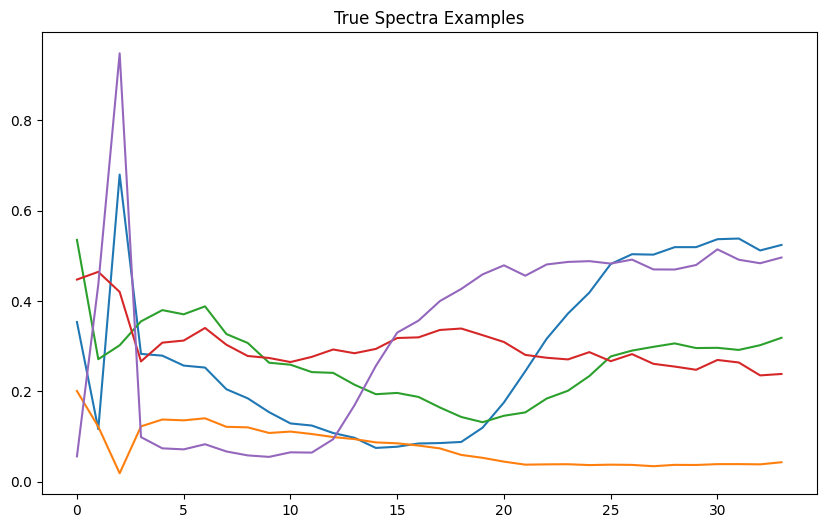

In [35]:
import matplotlib.pyplot as plt

# Assuming `spectra` is your list of length 10, where each element is of shape (1, 1, 34)
# We first squeeze out the unnecessary dimensions to get a 34-length array for each time step.

# Prepare the figure
plt.figure(figsize=(10, 6))

# Plot each spectrum in the `spectra` list
for i, spectrum in enumerate(mini_portion):
    # Squeeze the array to get rid of extra dimensions (assuming spectra[i] has shape (1, 1, 34))
    spectrum = spectrum.squeeze()#.numpy()  # Convert to numpy for plotting if it's a tensor

    # Plot the line for each time step
    plt.plot(range(34), spectrum)

# Add labels and title
plt.title('True Spectra Examples');

In [36]:
np.save("1mil_pixel_data.npy", final_portion)